<a href="https://colab.research.google.com/github/tahsinac/other-projects/blob/master/talkingdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TalkingData AdTracking Fraud Detection

## Introduction

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
files = os.listdir('gdrive/My Drive/Colab Notebooks/Colab Data/TalkingData')
files

['test.csv', 'train_sample.csv', 'train.csv']

**The data can be found [here](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/data).**

In [0]:
# Getting training and testing datasets

testdf = pd.read_csv('gdrive/My Drive/Colab Notebooks/Colab Data/TalkingData/test.csv')
traindf = pd.read_csv('gdrive/My Drive/Colab Notebooks/Colab Data/TalkingData/train.csv',nrows = 1000000)

In [4]:
traindf.head(3)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0


In [5]:
testdf.head(3)

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00


In [6]:
traindf.shape

(1000000, 8)

In [7]:
testdf.shape

(18790469, 7)

***Columns***

* **ip**: ip address of click
* **app**: app id for marketing
* **device**: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
* **os**: os version id of user mobile phone
* **channel**: channel id of mobile ad publisher
* **click_time**: timestamp of click (UTC)
* **attributed_time**: if user download the app for after clicking an ad, this is the time of the app download
* **is_attributed**: the target that is to be predicted, indicating the app was downloaded


In [8]:
for c in traindf.columns:
  print('{0} datatype : {1}'.format(c, traindf[c].dtype))

ip datatype : int64
app datatype : int64
device datatype : int64
os datatype : int64
channel datatype : int64
click_time datatype : object
attributed_time datatype : object
is_attributed datatype : int64


However, here ip, app, device, channel are categorical values encoded as integers.

In [0]:
# Changing datatype to categorical

cat_cols = ['ip', 'app', 'device', 'os', 'channel']

for c in cat_cols:
  traindf[c] = traindf[c].astype('category')
  testdf[c] = testdf[c].astype('category')
 
traindf['is_attributed'] = traindf['is_attributed'].astype('category')
testdf['click_id'] = testdf['click_id'].astype('category')

In [0]:
# Converting click_time and attributed_time to datetime

traindf['click_time'] = pd.to_datetime(traindf['click_time'])
traindf['attributed_time'] = pd.to_datetime(traindf['attributed_time'])
testdf['click_time'] = pd.to_datetime(testdf['click_time'])

#traindf['hour'] = traindf['click_time'].dt.hour
#traindf['day'] = traindf['click_time'].dt.day

## Data Analysis

In [11]:
traindf.describe()[1:2]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
unique,39611.0,214.0,298.0,160.0,154.0,1731,1530,2.0


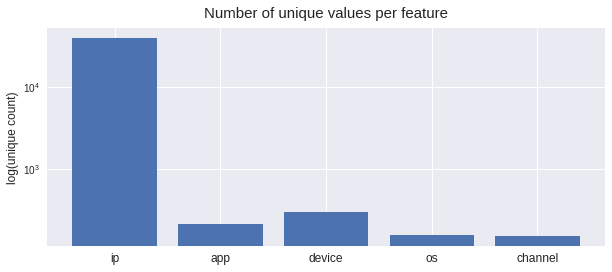

In [12]:
plt.figure(figsize=(10, 4))
plt.bar(range(5),traindf.describe()[1:2].values.tolist()[0][0:5], log = True, tick_label = traindf.columns.tolist()[0:5])
plt.xticks(fontsize = 12)
plt.title('Number of unique values per feature', fontsize  = 15, y = 1.02)
plt.ylabel('log(unique count)', fontsize = 12)
plt.show()

In [13]:
traindf[['attributed_time', 'is_attributed']][traindf['is_attributed']==1].describe()

,attributed_time,is_attributed
count,1693,1693.0
unique,1530,1.0
top,2017-11-06 16:22:12,1.0
freq,4,1693.0
first,2017-11-06 16:00:47,NaN
last,2017-11-07 15:55:31,NaN


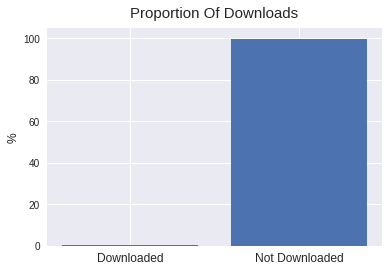

In [15]:
perc_dls = (traindf['is_attributed']==1).mean() * 100

plt.bar(range(2), [perc_dls, 100 - perc_dls], tick_label = ['Downloaded', 'Not Downloaded'])
plt.xticks(fontsize = 12)
plt.title('Proportion Of Downloads', fontsize  = 15, y = 1.02)
plt.ylabel('%', fontsize = 12)
plt.show()

### Exploring IPs

In [16]:
traindf['ip'].value_counts().sort_values(ascending = False)[0:5]

73487     6437
73516     6317
105560    3474
5314      3367
5348      3057
Name: ip, dtype: int64

* Only 18,717 out of 10,000,000 clicks result in a download. That is around 0.2%!
* There are IP adresses that trigger a click over 50k times in 4 days. This could either mean that these are bots or the ip address encoded is not device id, but network id.




In [17]:
traindf[traindf['is_attributed']==1]['ip'].describe()

count      1693
unique     1632
top       73487
freq          5
Name: ip, dtype: int64

So, high frequency ip counts do get downloads, as many as 56 for a single ip. This means each IP is for a network with many devices. 

### Conversions By IP

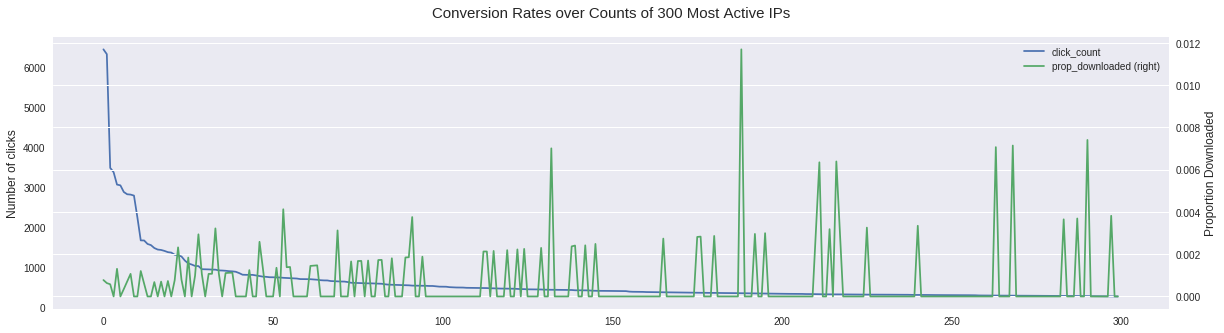

In [19]:
# coverting is_attributed back to numeric for group by calculations
traindf['is_attributed']=traindf['is_attributed'].astype(int)

prop_count = traindf[['ip', 'is_attributed']].groupby('ip', as_index=False).agg(['count', 'mean'])
prop_count = prop_count.reset_index()
prop_count = prop_count.sort_values([('is_attributed', 'count')], ascending = False)
prop_count.columns = prop_count.columns.droplevel()
prop_count.columns = ['ip', 'click_count', 'prop_downloaded']
indx = []
for i in range(prop_count.shape[0]):
  indx.append(i)
prop_count['index'] = indx
prop_count.set_index(keys = 'index', inplace = True, drop = True)

ax = prop_count[:300].plot(secondary_y='prop_downloaded', figsize = (20,5))
plt.title('Conversion Rates over Counts of 300 Most Active IPs', fontsize = 15, y = 1.05)
ax.set_ylabel('Number of clicks', fontsize = 12)
ax.set_xlabel('')
plt.ylabel('Proportion Downloaded', fontsize = 12)
plt.show()

There seems to be no relation between how active an IP and the conversions.

### Conversions By Apps

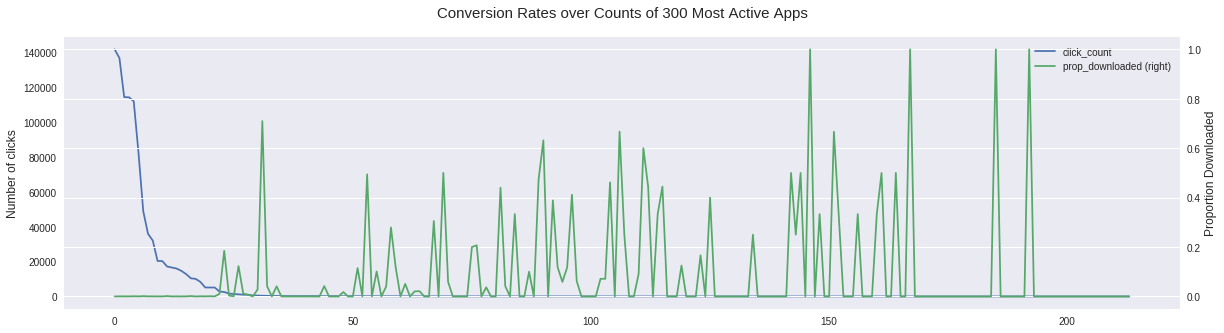

In [20]:
prop_count = traindf[['app', 'is_attributed']].groupby('app', as_index=False).agg(['count', 'mean'])
prop_count = prop_count.reset_index()
prop_count = prop_count.sort_values([('is_attributed', 'count')], ascending = False)
prop_count.columns = prop_count.columns.droplevel()
prop_count.columns = ['app', 'click_count', 'prop_downloaded']
indx = []
for i in range(prop_count.shape[0]):
  indx.append(i)
prop_count['index'] = indx
prop_count.set_index(keys = 'index', inplace = True, drop = True)

ax = prop_count[:300].plot(secondary_y='prop_downloaded', figsize = (20,5))
plt.title('Conversion Rates over Counts of 300 Most Active Apps', fontsize = 15, y = 1.05)
ax.set_ylabel('Number of clicks', fontsize = 12)
ax.set_xlabel('')
plt.ylabel('Proportion Downloaded', fontsize = 12)
plt.show()

The proportion flucuates more as the counts go down, since each additional click has larger impact on the proportion value. In general, for apps with counts in the thousands the ratio stays within 0.0001 - 0.0015 boundary. For less popular apps, there is more fluctioation.

### Conversions By OS

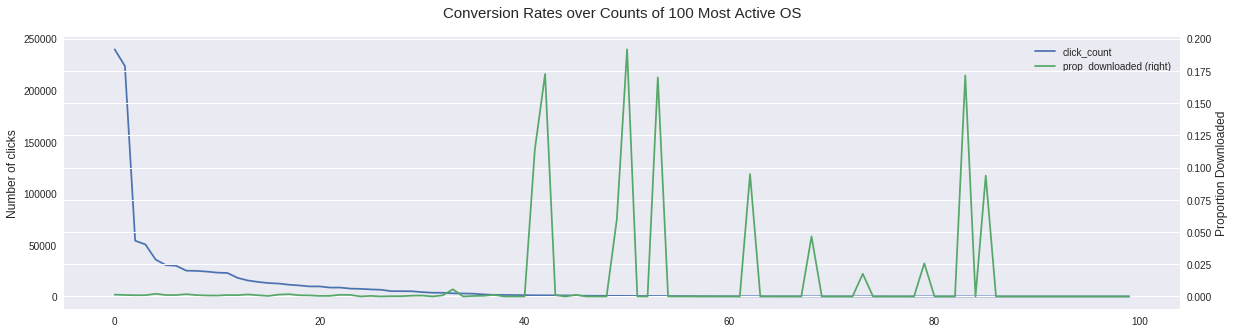

In [24]:
prop_count = traindf[['os', 'is_attributed']].groupby('os', as_index=False).agg(['count', 'mean'])
prop_count = prop_count.reset_index()
prop_count = prop_count.sort_values([('is_attributed', 'count')], ascending = False)
prop_count.columns = prop_count.columns.droplevel()
prop_count.columns = ['os', 'click_count', 'prop_downloaded']
indx = []
for i in range(prop_count.shape[0]):
  indx.append(i)
prop_count['index'] = indx
prop_count.set_index(keys = 'index', inplace = True, drop = True)

ax = prop_count[:100].plot(secondary_y='prop_downloaded', figsize = (20,5))
plt.title('Conversion Rates over Counts of 100 Most Active OS', fontsize = 15, y = 1.05)
ax.set_ylabel('Number of clicks', fontsize = 12)
ax.set_xlabel('')
plt.ylabel('Proportion Downloaded', fontsize = 12)
plt.show()


### Conversions By Device

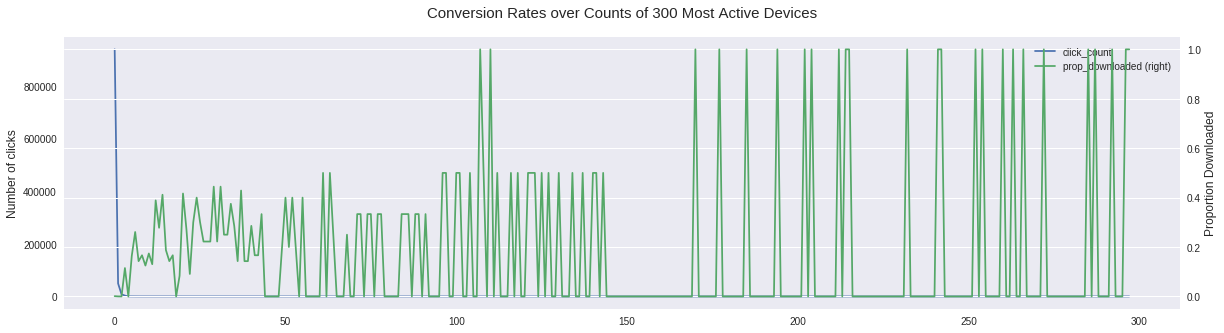

In [22]:
prop_count = traindf[['device', 'is_attributed']].groupby('device', as_index=False).agg(['count', 'mean'])
prop_count = prop_count.reset_index()
prop_count = prop_count.sort_values([('is_attributed', 'count')], ascending = False)
prop_count.columns = prop_count.columns.droplevel()
prop_count.columns = ['device', 'click_count', 'prop_downloaded']
indx = []
for i in range(prop_count.shape[0]):
  indx.append(i)
prop_count['index'] = indx
prop_count.set_index(keys = 'index', inplace = True, drop = True)

ax = prop_count[:300].plot(secondary_y='prop_downloaded', figsize = (20,5))
plt.title('Conversion Rates over Counts of 300 Most Active Devices', fontsize = 15, y = 1.05)
ax.set_ylabel('Number of clicks', fontsize = 12)
ax.set_xlabel('')
plt.ylabel('Proportion Downloaded', fontsize = 12)
plt.show()

### Conversions By Channels

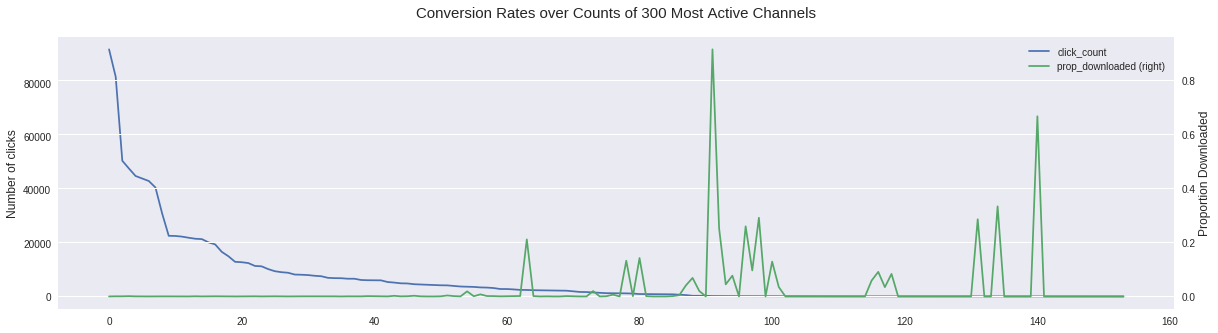

In [25]:
prop_count = traindf[['channel', 'is_attributed']].groupby('channel', as_index=False).agg(['count', 'mean'])
prop_count = prop_count.reset_index()
prop_count = prop_count.sort_values([('is_attributed', 'count')], ascending = False)
prop_count.columns = prop_count.columns.droplevel()
prop_count.columns = ['channel', 'click_count', 'prop_downloaded']
indx = []
for i in range(prop_count.shape[0]):
  indx.append(i)
prop_count['index'] = indx
prop_count.set_index(keys = 'index', inplace = True, drop = True)

ax = prop_count[:300].plot(secondary_y='prop_downloaded', figsize = (20,5))
plt.title('Conversion Rates over Counts of 300 Most Active Channels', fontsize = 15, y = 1.05)
ax.set_ylabel('Number of clicks', fontsize = 12)
ax.set_xlabel('')
plt.ylabel('Proportion Downloaded', fontsize = 12)
plt.show()

### Exploring Time Patterns

In this section, we will check if there are any hourly patterns.

As the dataset is ordered by time, we cannot just use the first 10000000 rows of the data. Instead, we will have to use the training data from the randomly sampled 100000 train set provided.

In [0]:
trainsm = pd.read_csv('gdrive/My Drive/Colab Notebooks/Colab Data/TalkingData/train_sample.csv')
trainsm['attributed_time'] = pd.to_datetime(trainsm['attributed_time'])
trainsm['click_time'] = pd.to_datetime(trainsm['click_time'])

trainsm['click_nearest_hour'] = trainsm['click_time'].dt.round('H')
trainsm['click_hour'] = trainsm['click_nearest_hour'].dt.hour
trainsm['click_day'] = trainsm['click_time'].dt.day

In [27]:
trainsm.head(2)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_nearest_hour,click_hour,click_day
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017-11-07 10:00:00,10,7
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017-11-07 14:00:00,14,7


In [0]:
time_count = trainsm[['click_nearest_hour', 'is_attributed']].groupby('click_nearest_hour', as_index=False).agg(['count', 'mean'])
time_count = time_count.reset_index()
time_count.columns = time_count.columns.droplevel()
time_count.columns = ['click_nearest_hour', 'click_count', 'prop_downloaded']
time_count.set_index(keys = 'click_nearest_hour', inplace = True, drop = True)

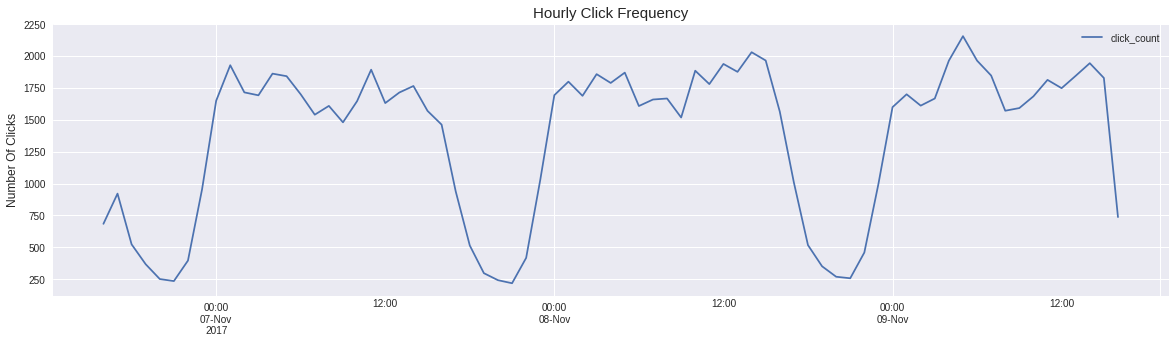

In [29]:
time_count.plot(y='click_count', figsize = (20,5))
plt.xlabel('')
plt.ylabel('Number Of Clicks', fontsize  = 12)
plt.title('Hourly Click Frequency', fontsize = 15)
plt.show()

There's a clear thrend in the amount of clicks. There seems to be a very high frequency of clicks between midnight and mid day. and very low frequencies right before midnight.

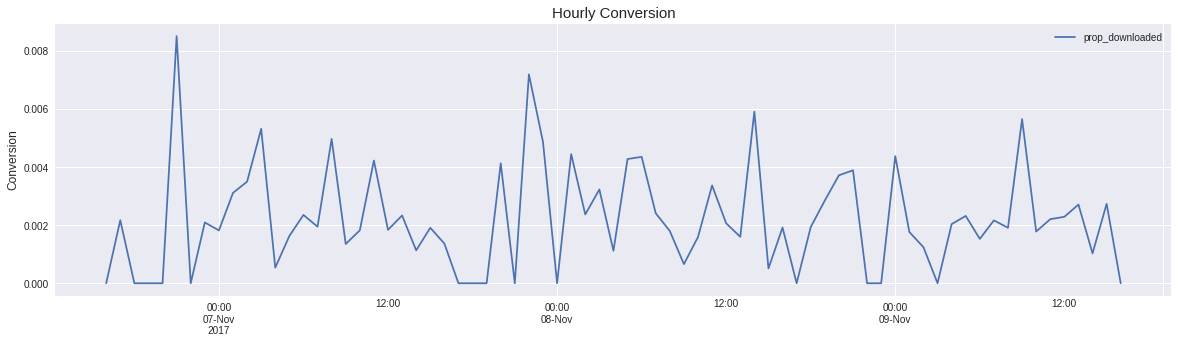

In [30]:
time_count.plot(y='prop_downloaded', figsize = (20,5))
plt.xlabel('')
plt.ylabel('Conversion', fontsize  = 12)
plt.title('Hourly Conversion', fontsize = 15)
plt.show()

There is no apparent trend in conversion ratio.

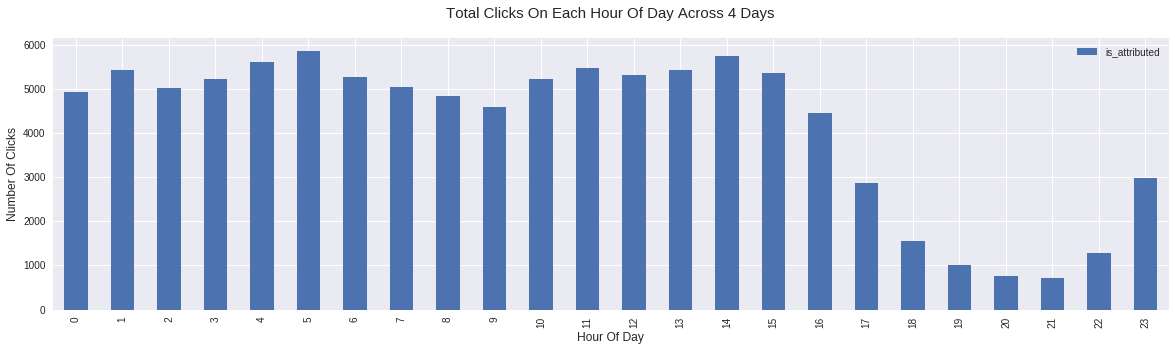

In [31]:
trainsm[['click_hour', 'is_attributed']].groupby(['click_hour'], as_index = True).count().plot(kind = 'bar', figsize = (20,5))
plt.title('Total Clicks On Each Hour Of Day Across 4 Days', fontsize = 15, y = 1.05)
plt.ylabel('Number Of Clicks', fontsize = 12)
plt.xlabel('Hour Of Day', fontsize = 12)
plt.show()

Number of clicks that occur between midnight and 5 pm are very high and remain somewhat comparable throughout this period. The number of clicks are quite low between 6 pm and 10 pm.

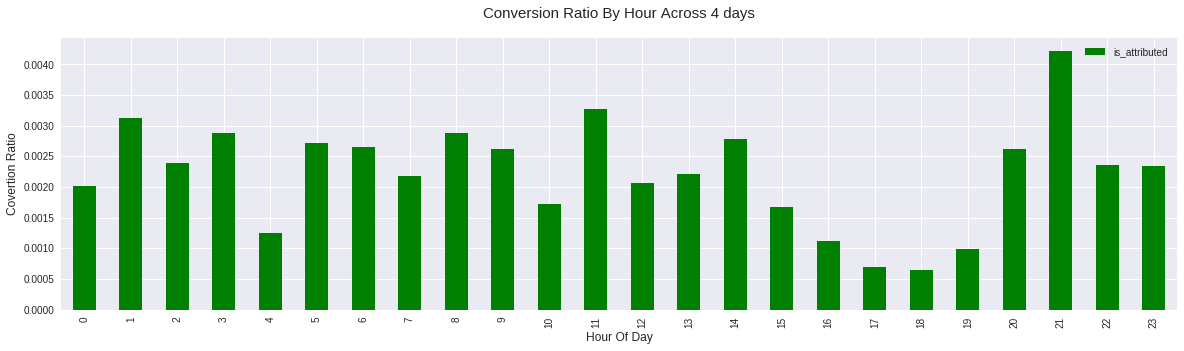

In [32]:
trainsm[['click_hour', 'is_attributed']].groupby(['click_hour'], as_index = True).mean().plot(kind = 'bar', figsize = (20,5), color = 'green')
plt.title('Conversion Ratio By Hour Across 4 days', fontsize = 15, y = 1.05)
plt.ylabel('Covertion Ratio', fontsize = 12)
plt.xlabel('Hour Of Day', fontsize = 12)
plt.show()

### Exploring Attributed Time

A look into how much time passed between clicking an ad and downloading it can give us some useful insights.

In [33]:
trainsm['time_passed'] = trainsm['attributed_time'] - trainsm['click_time']
trainsm['time_passed'].describe()

count                       227
mean     0 days 01:14:59.572687
std      0 days 02:25:05.392661
min             0 days 00:00:02
25%      0 days 00:00:52.500000
50%             0 days 00:03:18
75%      0 days 01:21:27.500000
max             0 days 12:52:21
Name: time_passed, dtype: object

The minimum time that passed between clicking and downloading is as little as 2 seconds. This could mean a few things:
* The person downloading was already aware of the product or saw the had before and had already decided to download before hand.
*  This could be the result of an error on the algorigthm of the bots as 2 seconds is quite fast a reaction time for a human.



## Predicting Frauds

For this project we will be using the random samples of 100000 records from both the test and train datasets.

In [0]:
testdf = testdf.sample(n = 100000, random_state = 1)

In [0]:
cat_cols = ['ip', 'app', 'device', 'os', 'channel', 'is_attributed']

for c in cat_cols:
  trainsm[c] = trainsm[c].astype('category')

In [0]:
trainsm.drop(['click_time', 'attributed_time', 'click_nearest_hour', 'time_passed'], axis=1, inplace = True)

In [0]:
target = trainsm['is_attributed']
trainsm.drop(['is_attributed'], axis=1, inplace = True)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(trainsm, target, test_size = 0.2)

### Testing Out Different Models

In [0]:
from sklearn.metrics import fbeta_score, recall_score

Here, We are more interested in getting a higher recall score as we are more interested in catching the true positives.

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
fscore = fbeta_score(y_test, preds, beta = 1)
recall = recall_score(y_test, preds)

print('recall : {0}\nf1 score: {1}'.format(recall, fscore))

recall : 0.2
f1 score: 0.25641025641025644


In [40]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
fscore = fbeta_score(y_test, preds, beta = 1)
recall = recall_score(y_test, preds)

print('recall : {0}\nf1 score: {1}'.format(recall, fscore))

recall : 0.36
f1 score: 0.34285714285714286


In [60]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)
preds = model.predict(X_test)
fscore = fbeta_score(y_test, preds, beta = 1)
recall = recall_score(y_test, preds)

print('recall : {0}\nf1 score: {1}'.format(recall, fscore))

recall : 0.7
f1 score: 0.012161223071577484


In [42]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())
model.fit(X_train, y_train)
preds = model.predict(X_test)
fscore = fbeta_score(y_test, preds, beta = 1)
recall = recall_score(y_test, preds)

print('recall : {0}\nf1 score: {1}'.format(recall, fscore))

recall : 0.36
f1 score: 0.3364485981308411


In [62]:
params = {'n_estimators' : [50, 100, 200, 250, 500, 1000], 'learning_rate' : [0.0001,0.001,0.1,1,1.2,2]}
scorer = make_scorer(recall_score)
clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())
grid_obj = GridSearchCV(clf, params, scoring = scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_
bestpreds = best_clf.predict(X_test)

fscore = fbeta_score(y_test, bestpreds, beta = 1)
recall = recall_score(y_test, bestpreds)

print('recall : {0}\nf1 score: {1}'.format(recall, fscore))

recall : 0.38
f1 score: 0.35185185185185186
